# Contextualized Regression
Contextual models allow to identify heterogeneous effects which change between different contexts. The `contextualized` package provides easy access to these heterogeneous models through the `contextualized.easy` module interfaces. This notebook shows a simple example of using `contextualized.easy` regression. 

Note: These `contextualized.easy` interfaces don't try to use best PyTorch practices (prioritizing easy use over computational efficiency), so it's recommended to use `contextualized` models for any heavy lifting (see this [demo](https://github.com/cnellington/Contextualized/blob/main/docs/demos/custom_models.ipynb)).

## 1. Generate Simulation Data
In this simulated regression, we'll study the simple varying-coefficients case where $Y =X\beta(C) + \epsilon$, with $\beta(C) \sim \text{N}(C\phi, \text{I})$.

In [1]:
import numpy as np
n_samples = 1000
n_outcomes = 3
n_context = 1
n_observed = 1
C = np.random.uniform(-1, 1, size=(n_samples, n_context))
X = np.random.uniform(0, 0.5, size=(n_samples, n_observed))
phi = np.random.uniform(-1, 1, size=(n_context, n_observed, n_outcomes))
beta = np.tensordot(C, phi, axes=1) + np.random.normal(0, 0.01, size=(n_samples, n_observed, n_outcomes))
Y = np.array([np.tensordot(X[i], beta[i], axes=1) for i in range(n_samples)])

## 2. Build and fit model
Uses an sklearn-type wrapper interface.

In [2]:
%%capture
from contextualized.easy import ContextualizedRegressor
model = ContextualizedRegressor()
model.fit(C, X, Y, max_epochs=20, learning_rate=1e-3, n_bootstraps=3)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Common constructor keywords include:

    - n_bootstraps: The integer number of bootstrap runs to fit.
    - encoder_type: 'mlp' or 'ngam', which type of model to make as context encoder.
    - loss_fn: A function to calculate loss (see 'contextualized.regression.LOSSES')
    - alpha: non-negative float, regularization strength.
    - mu_ratio: float in range (0.0, 1.0), governs how much the regularization applies to context-specific parameters or context-specific offsets.
    - l1_ratio: float in range (0.0, 1.0), governs how much the regularization penalizes l1 vs l2 parameter norms.

Common fitting keywords include:

    - max_epochs: positive number, the maximum number of epochs to fit. Early stopping is turned on by default.
    - learning_rate: positive float, default is 1e-3.
    - val_split: float in range (0.0, 1.0), how much of the data to use for validation (early stopping).

## 3. Inspect the model predictions.

In [3]:
%%capture
import matplotlib.pyplot as plt
%matplotlib inline
preds = model.predict(C, X)[:, 0]

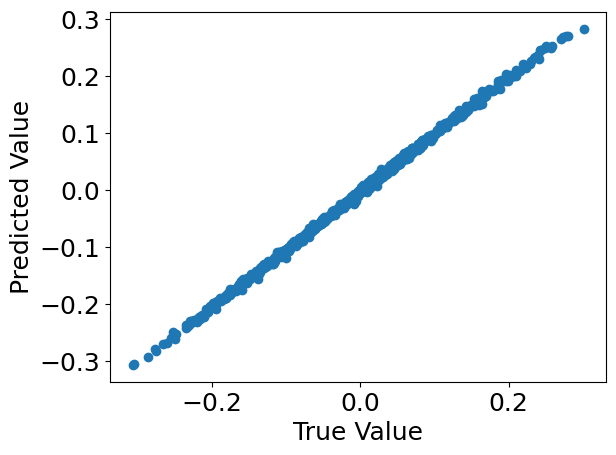

In [4]:
plt.rcParams.update({'font.size': 18})
plt.scatter(Y[:, 0], preds)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

## 4. Check what the individual bootstrap models learned.

In [5]:
%%capture
model_preds = model.predict(C, X, individual_preds=True)

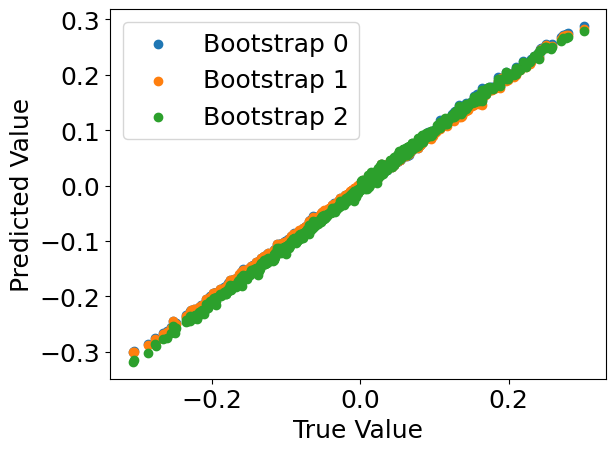

In [6]:
for i, pred in enumerate(model_preds):
    plt.scatter(Y[:, 0], pred[:, 0], label='Bootstrap {}'.format(i))
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

## 5. Check what parameters the models learned.

In [7]:
%%capture
beta_preds, mu_preds = model.predict_params(C, individual_preds=True)

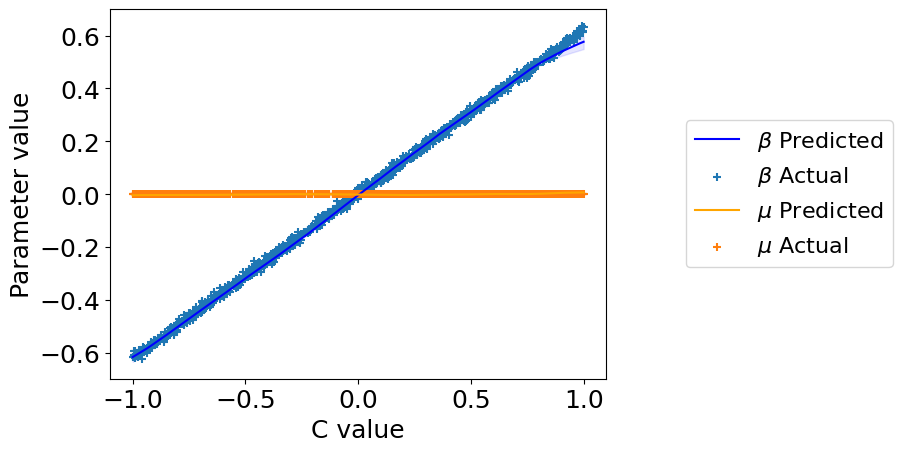

In [8]:
order = np.argsort(C.squeeze())  # put C in order for plotting
C = C[order].squeeze()
beta_preds = beta_preds[:, order]
mu_preds = mu_preds[:, order]
beta = beta[order]

plt.plot(
    C, np.mean(beta_preds[:, :, 0], axis=0),
            label='$\\beta$ Predicted', color='blue')
plt.fill_between(
    C,
    np.percentile(beta_preds[:, :, 0], 2.5, axis=0).squeeze(),
    np.percentile(beta_preds[:, :, 0], 97.5, axis=0).squeeze(),
    color='blue', alpha=0.1
)
plt.scatter(C, beta[:, :, 0], label='$\\beta$ Actual', marker='+')

plt.plot(
    C, np.mean(mu_preds[:, :, 0], axis=0),
            label='$\\mu$ Predicted', color='orange')
plt.fill_between(
    C,
    np.percentile(mu_preds[:, :, 0], 2.5, axis=0).squeeze(),
    np.percentile(mu_preds[:, :, 0], 97.5, axis=0).squeeze(),
    color='orange', alpha=0.1
)
plt.scatter(C, np.zeros_like(C), label='$\\mu$ Actual', marker='+')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), fontsize=16)
plt.xlabel("C value")
plt.ylabel("Parameter value")
plt.show()

## 6. Save/load the trained model.

In [9]:
from contextualized.utils import save, load

save_path = './easy_demo_model.pt'
save(model, path=save_path)
model = load(save_path)